In [ ]:
Poniżej importuję potrzebne biblioteki, wczytuję dane z plików tekstowych, przetwarzam je i tworzę z nich DataFrame.
Dane na temat grubości warstw i współczynników A,B,C są zapisane w nazwach plików, więc wyciągam je z nazw plików i dodaję do DataFrame.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define the path to the folder
folder_path = os.path.join("datasets", "Si_jaw", "")
os.makedirs(folder_path, exist_ok=True)
# Get a list of all items in the folder
all_items = os.listdir(folder_path)

# Filter the list to include only files
files = [item for item in all_items if os.path.isfile(os.path.join(folder_path, item))]

dataFrame = pd.DataFrame()



for i in files:
    dataHelper = pd.read_csv(folder_path + i, sep='\t', header=None, index_col=False)
    info = i.split('_')
    T = info[0]
    A = info[1]
    B = info[2]
    C = info[3]
    dataHelper = dataHelper.drop(index = [0])
    dataHelper = dataHelper.drop(columns = [7])
    dataHelper.columns = ['wavelength', 'psi60', 'psi65', 'psi70','psi60*','psi65*','psi70*']
    dataHelper['T'] = T
    dataHelper['A'] = A
    dataHelper['B'] = B
    dataHelper['C'] = C.removesuffix(".txt")
    dataFrame = pd.concat([dataFrame, dataHelper], ignore_index=True)



dataFrame.head()
    

,wavelength,psi60,psi65,psi70,psi60*,psi65*,psi70*,T,A,B,C
0,300.0,36.787,36.905,37.947,37.511,37.209,37.514,101,1.305,0.0095,0.0001
1,301.0,36.785,36.957,38.045,37.295,36.907,37.453,101,1.305,0.0095,0.0001
2,302.0,36.796,37.020,38.151,37.087,36.772,37.279,101,1.305,0.0095,0.0001
3,303.0,36.818,37.093,38.264,37.019,36.553,37.024,101,1.305,0.0095,0.0001
4,304.0,36.850,37.176,38.385,36.990,36.489,37.052,101,1.305,0.0095,0.0001


Poniżej standaryzuję dane i dzielę je na zbiory treningowe i testowe. Następnie tworzę modele regresji liniowej dla każdego z parametrów T, A, B, C.
Jako feature'y wykorzystuję dane o długości fali i wartościach psi dla kątów 60, 65, 70 stopni.


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

Xall = dataFrame[['wavelength', 'psi60', 'psi65', 'psi70']]
Xscaled = MinMaxScaler().fit_transform(Xall)
XscaledAndNamed = pd.DataFrame(Xscaled, columns=['wavelength', 'psi60', 'psi65', 'psi70'])
T = dataFrame['T']
Tscaled = MinMaxScaler().fit_transform(T.values.reshape(-1,1))
TscaledAndNamed = pd.DataFrame(Tscaled, columns=['T'])
A = dataFrame['A']
Ascaled = MinMaxScaler().fit_transform(A.values.reshape(-1,1))
AscaledAndNamed = pd.DataFrame(Ascaled, columns=['A'])
B = dataFrame['B']
Bscaled = MinMaxScaler().fit_transform(B.values.reshape(-1,1))
BscaledAndNamed = pd.DataFrame(Bscaled, columns=['B'])
C = dataFrame['C']
Cscaled = MinMaxScaler().fit_transform(C.values.reshape(-1,1))
CscaledAndNamed = pd.DataFrame(Cscaled, columns=['C'])


tx_train, tx_test, ty_train, ty_test = train_test_split(XscaledAndNamed, TscaledAndNamed, test_size=0.2, random_state=42)
ax_train, ax_test, ay_train, ay_test = train_test_split(XscaledAndNamed, AscaledAndNamed, test_size=0.2, random_state=42)
bx_train, bx_test, by_train, by_test = train_test_split(XscaledAndNamed, BscaledAndNamed, test_size=0.2, random_state=42)
cx_train, cx_test, cy_train, cy_test = train_test_split(XscaledAndNamed, CscaledAndNamed, test_size=0.2, random_state=42)

multi_regT = LinearRegression()
multi_regT.fit(tx_train, ty_train)
multi_regA = LinearRegression()
multi_regA.fit(ax_train, ay_train)
multi_regB = LinearRegression()
multi_regB.fit(bx_train, by_train)
multi_regC = LinearRegression()
multi_regC.fit(cx_train, cy_train)



LinearRegression()

Obliczam błąd średniokwadratowy dla każdego z modeli i porównuję go z wariancją danych testowych.
Wyniki są słabe, co sugeruje, że model nie jest w stanie przewidzieć wartości zadowalająco.


In [3]:
multiregT_predictions = multi_regT.predict(tx_test)
multiregA_predictions = multi_regA.predict(ax_test)
multiregB_predictions = multi_regB.predict(bx_test)
multiregC_predictions = multi_regC.predict(cx_test)

from sklearn.metrics import mean_squared_error
mseT = mean_squared_error(ty_test, multiregT_predictions)
mseA = mean_squared_error(ay_test, multiregA_predictions)
mseB = mean_squared_error(by_test, multiregB_predictions)
mseC = mean_squared_error(cy_test, multiregC_predictions)
print("MSE dla T: ", mseT)
print("Wariancja dla T: ", ty_test.var())
print("MSE dla A: ", mseA)
print("Wariancja dla A: ", ay_test.var())
print("MSE dla B: ", mseB)
print("Wariancja dla B: ", by_test.var())
print("MSE dla C: ", mseC)
print("Wariancja dla C: ", cy_test.var())

MSE dla T:  0.039318756440044435
Wariancja dla T:  T    0.091474
dtype: float64
MSE dla A:  0.13177822573576553
Wariancja dla A:  A    0.134381
dtype: float64
MSE dla B:  0.14950644620140943
Wariancja dla B:  B    0.150031
dtype: float64
MSE dla C:  0.08191252838859547
Wariancja dla C:  C    0.082626
dtype: float64


Poniżej sprawdzam jak wielomiany o różnych stopniach można dopasować do danych. Widać, że nawet wielomian stopnia 6 nie
jest zbyt dopasowany do danych treningowych.

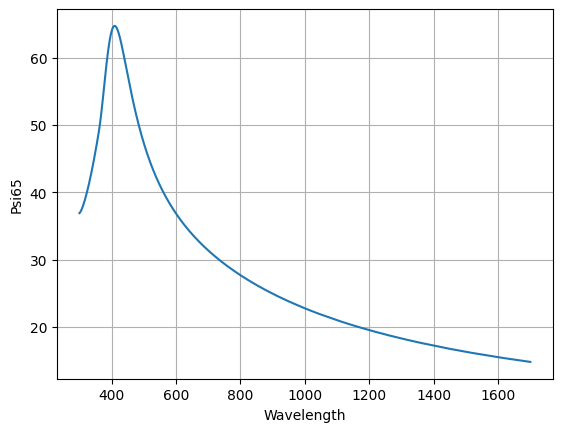

In [4]:
dataHelper = pd.read_csv(folder_path + files[0], sep='\t', header=None, index_col=False)
dataHelper = dataHelper.drop(index = [0])
dataHelper = dataHelper.drop(columns = [7])
dataHelper.columns = ['wavelength', 'psi60', 'psi65', 'psi70','psi60*','psi65*','psi70*']
from matplotlib import pyplot as plt
x = dataHelper['wavelength']
y = dataHelper['psi65']
plt.plot(x, y)
plt.xlabel('Wavelength')
plt.ylabel('Psi65')
plt.grid()



Text(0, 0.5, 'Psi65')

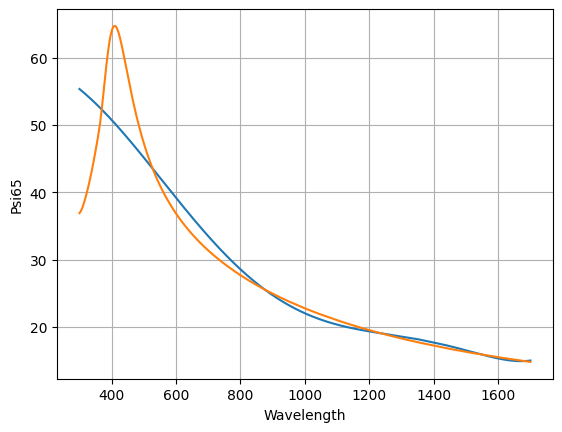

In [5]:
from sklearn.preprocessing import PolynomialFeatures
polyFeatures = PolynomialFeatures(degree=6)
polyReg = LinearRegression()
polyX = polyFeatures.fit_transform(x.values.reshape(-1,1))
polyY = y.values.reshape(-1,1)
polyReg.fit(polyX, polyY)
polyPredictions = polyReg.predict(polyX)
plt.plot(x, polyPredictions)
plt.plot(x, y)
plt.grid()
plt.xlabel('Wavelength')
plt.ylabel('Psi65')



Pomimo słabego dopasowania wielomianu 6 stopnia do danych treningowych sprawdzam jak model regresji liniowej 
poradzi sobie z przewidywaniem wartości T, A, B, C na podstawie współczynników wielomianu.
Idea jest taka że pomimo słabego dopasowania wielomianu do danych, to wartość każdego z jego współczynników
zależy od całego kształtu krzywej, tak jak cały kształt krzywej zależy od współczynników A,B,C i grubości, więc może być lepszym predyktorem
interesujących mnie wartości. Feature'y i targety standaryzuję, ponieważ ułatwia mi to oszacowanie jakości dopasowania - im rmse bliżej 0, tym lepiej.
Im bliżej wariancji, tym gorzej.
Dla każdego zestawu danych przypisuję więc wielomian 6 stopnia i przeprowadzam regresję liniową na współczynnikach.

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
polyFeatures = PolynomialFeatures(degree=6)
polyReg = LinearRegression()

newDataFrame = pd.DataFrame()
for i in files:
    dataHelper = pd.read_csv(folder_path + i, sep='\t', header=None, index_col=False)
    info = i.split('_')
    T = info[0]
    A = info[1]
    B = info[2]
    C = info[3]
    dataHelper = dataHelper.drop(index = [0])
    dataHelper = dataHelper.drop(columns = [7])
    dataHelper.columns = ['wavelength', 'psi60', 'psi65', 'psi70','psi60*','psi65*','psi70*']
    dataHelper['T'] = T
    dataHelper['A'] = A
    dataHelper['B'] = B
    dataHelper['C'] = C.removesuffix(".txt")
    psi65 =dataHelper['psi65']
    wv = dataHelper['wavelength']
    vwPoly = polyFeatures.fit_transform(wv.values.reshape(-1,1))
    polyReg.fit(vwPoly, psi65)
    a1 = polyReg.coef_[1]
    a2 = polyReg.coef_[2]
    a3 = polyReg.coef_[3]
    a4 = polyReg.coef_[4]
    a5 = polyReg.coef_[5]
    a6 = polyReg.coef_[6]
    data = pd.Series([a1,a2,a3,a4,a5,a6, polyReg.intercept_,T,A,B,C.removesuffix(".txt")])
    df = data.to_frame().T
    newDataFrame = pd.concat([newDataFrame, df], ignore_index=True)


newDataFrame.columns = ['a1','a2','a3','a4','a5','a6','intercept', 'T', 'A', 'B', 'C']

newDataFrame.to_csv(folder_path + 'coefficients.csv', index=False)

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


coefficients = newDataFrame[['a1','a2','a3','a4','a5','a6','intercept']]
coefficients = MinMaxScaler().fit_transform(coefficients)

newYT = newDataFrame['T']
YTscaled = MinMaxScaler().fit_transform(newYT.values.reshape(-1,1))

newYA = newDataFrame['A']
YAscaled = MinMaxScaler().fit_transform(newYA.values.reshape(-1,1))

newYB = newDataFrame['B']
YBscaled = MinMaxScaler().fit_transform(newYB.values.reshape(-1,1))


newYC = newDataFrame['C']
YCscaled = MinMaxScaler().fit_transform(newYC.values.reshape(-1,1))



newXT_train, newXT_test, newYT_train, newYT_test = train_test_split(coefficients, YTscaled, test_size=0.2, random_state=0)
newXA_train, newXA_test, newYA_train, newYA_test = train_test_split(coefficients, YAscaled, test_size=0.2, random_state=0)
newXB_train, newXB_test, newYB_train, newYB_test = train_test_split(coefficients, YBscaled, test_size=0.2, random_state=0)
newXC_train, newXC_test, newYC_train, newYC_test = train_test_split(coefficients, YCscaled, test_size=0.2, random_state=0)

linRegA = LinearRegression()
linRegB = LinearRegression()
linRegC = LinearRegression()
linRegT = LinearRegression()

linRegA.fit(newXA_train, newYA_train)
linRegB.fit(newXB_train, newYB_train)
linRegC.fit(newXC_train, newYC_train)
linRegT.fit(newXT_train, newYT_train)


print("MSE dla T: ", mean_squared_error(newYT_test, linRegT.predict(newXT_test)))
print("wariancja dla T: ", newYT_test.var())
print("MSE dla A: ", mean_squared_error(newYA_test, linRegA.predict(newXA_test)))
print("wariancja dla A: ", newYA_test.var())
print("MSE dla B: ", mean_squared_error(newYB_test, linRegB.predict(newXB_test)))
print("wariancja dla B: ", newYB_test.var())
print("MSE dla C: ", mean_squared_error(newYC_test, linRegC.predict(newXC_test)))
print("wariancja dla C: ", newYC_test.var())




MSE dla T:  0.0027732683510677276
wariancja dla T:  0.08618887482948218
MSE dla A:  0.11043927339118687
wariancja dla A:  0.12878134430727026
MSE dla B:  0.14729428006313505
wariancja dla B:  0.14848955951836612
MSE dla C:  0.10510156280222116
wariancja dla C:  0.10827654320987655


Wyniki dla T unikły znacznej poprawie. Poprawił się także wynik dla A ale wciąż jest on daleki od zadawalającego.
Wyniki dla B i C są wciąż bardzo słabe. Wpadłem na pomysł że innym charakterystycznym punktem krzywej jest wartość maksymalna psi 
oraz odpowiadająca jej długość fali, więc postanowiłem dodać te wartości jako feature'y do modelu. Ponownie przeprowadzam obróbkę danych tym razem 
z dodatkowymi feature'ami.

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
polyFeatures = PolynomialFeatures(degree=6)
polyReg = LinearRegression()

newDataFrame = pd.DataFrame()
for i in files:
    dataHelper = pd.read_csv(folder_path + i, sep='\t', header=None, index_col=False)
    info = i.split('_')
    T = info[0]
    A = info[1]
    B = info[2]
    C = info[3]
    dataHelper = dataHelper.drop(index = [0])
    dataHelper = dataHelper.drop(columns = [7])
    dataHelper.columns = ['wavelength', 'psi60', 'psi65', 'psi70','psi60*','psi65*','psi70*']
    dataHelper['T'] = T
    dataHelper['A'] = A
    dataHelper['B'] = B
    dataHelper['C'] = C.removesuffix(".txt")
    psi65 =dataHelper['psi65']
    wv = dataHelper['wavelength']
    vwPoly = polyFeatures.fit_transform(wv.values.reshape(-1,1))
    polyReg.fit(vwPoly, psi65)
    a1 = polyReg.coef_[1]
    a2 = polyReg.coef_[2]
    a3 = polyReg.coef_[3]
    a4 = polyReg.coef_[4]
    a5 = polyReg.coef_[5]
    a6 = polyReg.coef_[6]
    psiMAX = dataHelper['psi65'].max()
    maxIndice = dataHelper['psi65'].idxmax()
    vwMAX = dataHelper['wavelength'][maxIndice]
    data = pd.Series([a1,a2,a3,a4,a5,a6, psiMAX, vwMAX, polyReg.intercept_,T,A,B,C.removesuffix(".txt")])
    df = data.to_frame().T
    newDataFrame = pd.concat([newDataFrame, df], ignore_index=True)

newDataFrame.columns = ['a1','a2','a3','a4','a5','a6','psiMAX','vwMAX','intercept', 'T', 'A', 'B', 'C']

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

coefficients = newDataFrame[['a1','a2','a3','a4','a5','a6','psiMAX','vwMAX','intercept']]
coefficients = MinMaxScaler().fit_transform(coefficients)

newYT = newDataFrame['T']
YTscaled = MinMaxScaler().fit_transform(newYT.values.reshape(-1,1))

newYA = newDataFrame['A']
YAscaled = MinMaxScaler().fit_transform(newYA.values.reshape(-1,1))

newYB = newDataFrame['B']
YBscaled = MinMaxScaler().fit_transform(newYB.values.reshape(-1,1))

newYC = newDataFrame['C']
YCscaled = MinMaxScaler().fit_transform(newYC.values.reshape(-1,1))


newXT_train, newXT_test, newYT_train, newYT_test = train_test_split(coefficients, YTscaled, test_size=0.2, random_state=0)
newXA_train, newXA_test, newYA_train, newYA_test = train_test_split(coefficients, YAscaled, test_size=0.2, random_state=0)
newXB_train, newXB_test, newYB_train, newYB_test = train_test_split(coefficients, YBscaled, test_size=0.2, random_state=0)
newXC_train, newXC_test, newYC_train, newYC_test = train_test_split(coefficients, YCscaled, test_size=0.2, random_state=0)


regT = LinearRegression()
regA = LinearRegression()
regB = LinearRegression()
regC = LinearRegression()

regT.fit(newXT_train, newYT_train)
regA.fit(newXA_train, newYA_train)
regB.fit(newXB_train, newYB_train)
regC.fit(newXC_train, newYC_train)

print("RMSE dla T: ", mean_squared_error(newYT_test, regT.predict(newXT_test)))
print("wariancja dla T: ", newYT_test.var())
print("RMSE dla A: ", mean_squared_error(newYA_test, regA.predict(newXA_test)))
print("wariancja dla A: ", newYA_test.var())
print("RMSE dla B: ", mean_squared_error(newYB_test, regB.predict(newXB_test)))
print("wariancja dla B: ", newYB_test.var())
print("RMSE dla C: ", mean_squared_error(newYC_test, regC.predict(newXC_test)))
print("wariancja dla C: ", newYC_test.var())




RMSE dla T:  0.0019328929080047192
wariancja dla T:  0.08618887482948218
RMSE dla A:  0.0758309994515664
wariancja dla A:  0.12878134430727026
RMSE dla B:  0.13962600964069163
wariancja dla B:  0.14848955951836612
RMSE dla C:  0.09433060989306988
wariancja dla C:  0.10827654320987655


Wyniki dla T i A są lepsze niż poprzednio, ale wciąż niezadowalające. Wyniki dla B i C są bardzo słabe.
Zastosowanie cechy charakterystycznej wykresu jaką jest jego wartość maksymalna wydała się być dobrym pomysłem, ale wciąż nie wystarczającym.
Stwierdziłem że można by uzyskać dużo lepsze dopasowanie wielomianu do jednej strony wykresu patrząc od jego wartośći maksymalnej. Być może pozwoliłoby to
na uzyskanie lepszych dopasowań dla niektórych współczynników Cauchy'ego, jako że każdy z nich ma dominujący wpływ w pewnym obszarze wykresu.
Dla próby podzieliłem dane na dwie części - lewą i prawą względem wartości maksymalnej psi65. Następnie dopasowałem do nich wielomiany 4 stopnia.
Wielomiany poniżej tego stopnia nie byłyby w stanie dobrze dopasować się do danych, a wyższe stopnie byłyby zbyt skomplikowane.

[ 0.00000000e+00 -3.59821766e+00  8.90254422e-03 -9.50747626e-06
  3.94822441e-09]
[ 0.00000000e+00 -2.12349189e+00  2.30351072e-03 -1.11954143e-06
  2.03797867e-10]


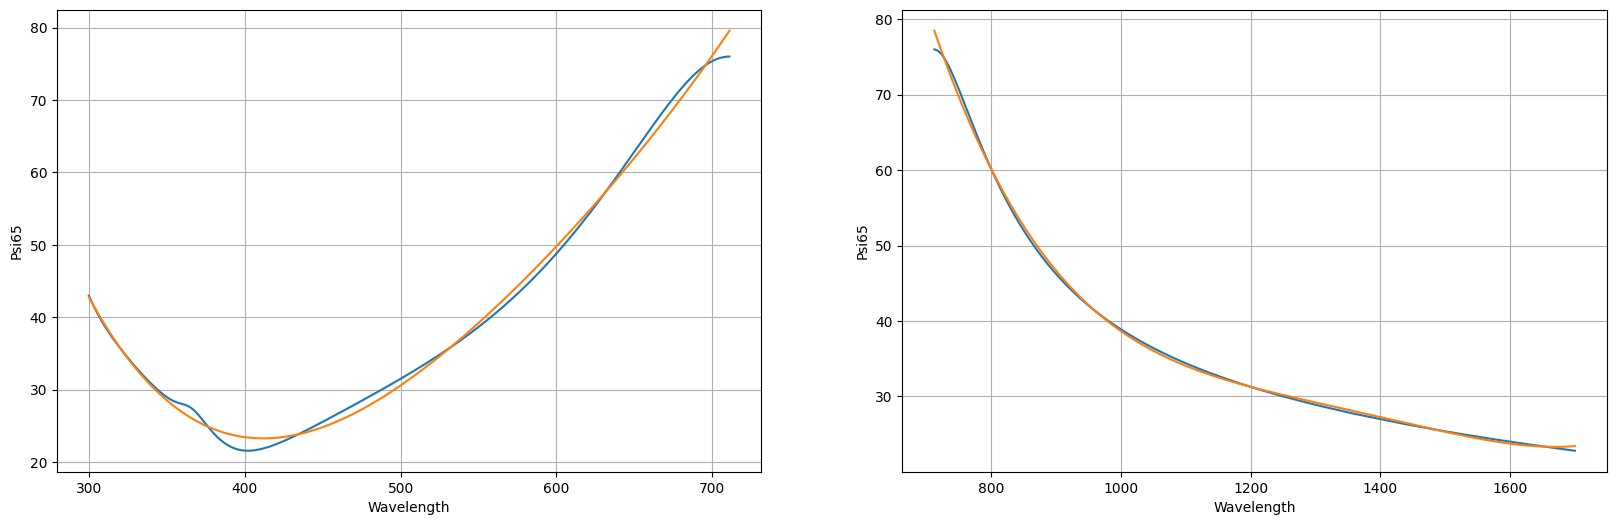

In [17]:
dataHelper = pd.read_csv(folder_path + files[200], sep='\t', header=None, index_col=False)
dataHelper = dataHelper.drop(index = [0])
dataHelper = dataHelper.drop(columns = [7])
dataHelper.columns = ['wavelength', 'psi60', 'psi65', 'psi70','psi60*','psi65*','psi70*']
from matplotlib import pyplot as plt
psiMAX = dataHelper['psi65'].max()
maxIndice = dataHelper['psi65'].idxmax()
vwMAX = dataHelper['wavelength'][maxIndice]
lDF = dataHelper[['wavelength', 'psi65']].iloc[:maxIndice]
rDF = dataHelper[['wavelength', 'psi65']].iloc[maxIndice:]
lX = lDF['wavelength']
lY = lDF['psi65']
rX = rDF['wavelength']
rY = rDF['psi65']
polyFeaturesL = PolynomialFeatures(degree=4)
polyFeaturesR = PolynomialFeatures(degree=4)
polyXL = polyFeaturesL.fit_transform(lX.values.reshape(-1,1))
polyXR = polyFeaturesR.fit_transform(rX.values.reshape(-1,1))
leftReg = LinearRegression()
rightReg = LinearRegression()
rightReg.fit(polyXR, rY)
leftReg.fit(polyXL, lY)
predYL = leftReg.predict(polyXL)
predYR = rightReg.predict(polyXR)
fig, ax = plt.subplots(1,2,figsize=(20,6))

ax[0].plot(lX, lY, label='Left Side')
ax[0].plot(lX, predYL, label='Polynomial Regression')
ax[0].grid()
ax[1].plot(rX, rY, label='Right Side')
ax[1].plot(rX, predYR, label='Polynomial Regression')
ax[1].grid()
ax[0].set_xlabel('Wavelength')
ax[0].set_ylabel('Psi65')
ax[1].set_xlabel('Wavelength')
ax[1].set_ylabel('Psi65')
print(leftReg.coef_)
print(rightReg.coef_)

Poniżej powtarzam powyższe akcje tylko dla całego zbioru danych. Jako feature'y wykorzystuję współczynniki wielomianów 4 stopnia oraz ich wyrazy wolne.
Używam także wartości psiMAX i vwMAX. Następnie z użyciem tych danych przeprowadzam regresję liniową.

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.signal import find_peaks
import numpy as np
polyFeaturesL = PolynomialFeatures(degree=4)
polyFeaturesR = PolynomialFeatures(degree=4)
polyRegL = LinearRegression()
polyRegR = LinearRegression()


newDataFrame = pd.DataFrame()
for i in files:
    dataHelper = pd.read_csv(folder_path + i, sep='\t', header=None, index_col=False)
    info = i.split('_')
    T = info[0]
    A = info[1]
    B = info[2]
    C = info[3]
    dataHelper = dataHelper.drop(index = [0])
    dataHelper = dataHelper.drop(columns = [7])
    dataHelper.columns = ['wavelength', 'psi60', 'psi65', 'psi70','psi60*','psi65*','psi70*']
    dataHelper['T'] = T
    dataHelper['A'] = A
    dataHelper['B'] = B
    dataHelper['C'] = C.removesuffix(".txt")
    peaks, _ = find_peaks(dataHelper['psi65'])
    psiMAX = dataHelper['psi65'].max()
    maxIndice = dataHelper['psi65'].idxmax()
    vwMAX = dataHelper['wavelength'][maxIndice]
    lDF = dataHelper[['wavelength', 'psi65']].iloc[:maxIndice]
    rDF = dataHelper[['wavelength', 'psi65']].iloc[maxIndice:]
    lX = lDF['wavelength']
    lY = lDF['psi65']
    lXScaled = MinMaxScaler().fit_transform(lX.values.reshape(-1,1))
    lYScaled = MinMaxScaler().fit_transform(lY.values.reshape(-1,1))
    rX = rDF['wavelength']
    rY = rDF['psi65']
    rXScaled = MinMaxScaler().fit_transform(rX.values.reshape(-1,1))
    rYScaled = MinMaxScaler().fit_transform(rY.values.reshape(-1,1))
    polyXL = polyFeaturesL.fit_transform(lXScaled)
    polyXR = polyFeaturesR.fit_transform(rXScaled)
    polyRegL.fit(polyXL, lYScaled)
    polyRegR.fit(polyXR, rYScaled)
    al1 = polyRegL.coef_[0][1]
    al2 = polyRegL.coef_[0][2]
    al3 = polyRegL.coef_[0][3]
    al4 = polyRegL.coef_[0][4]
    ar1 = polyRegR.coef_[0][1]
    ar2 = polyRegR.coef_[0][2]
    ar3 = polyRegR.coef_[0][3]
    ar4 = polyRegR.coef_[0][4]
    interl = polyRegL.intercept_
    interr = polyRegR.intercept_
    data = pd.Series([al1,al2,al3,al4 ,ar1,ar2, ar3, ar4,interl,interr, psiMAX, vwMAX, len(peaks),T,A,B,C.removesuffix(".txt")])
    df = data.to_frame().T
    newDataFrame = pd.concat([newDataFrame, df], ignore_index=True)

newDataFrame.columns = ['al1','al2','al3','al4','ar1','ar2','ar3','ar4','interl','interr','psiMAX','vwMAX','peaks', 'T', 'A', 'B', 'C']

In [19]:
newDataFrame.head()

,al1,al2,al3,al4,ar1,ar2,ar3,ar4,interl,interr,psiMAX,vwMAX,peaks,T,A,B,C
0,0.939236,-2.461614,6.184071,-3.626468,-4.950264,11.908579,-13.33463,5.435227,[-0.025252068827786467],[0.9709100940257472],64.749,409.0,1,101,1.305,0.0095,0.0001
1,0.931633,-2.327302,5.924708,-3.493704,-4.92965,11.814681,-13.204359,5.376304,[-0.024732183156004284],[0.9724132919317356],64.359,408.0,1,101,1.305,0.009,0.0001
2,0.948488,-2.445366,6.19901,-3.66784,-4.918299,11.804744,-13.206592,5.3809,[-0.025172075545547234],[0.9687561330703534],64.5,409.0,1,101,1.305,0.009,0.000130
3,0.946557,-2.463481,6.204238,-3.652524,-4.9339,11.8625,-13.282082,5.414064,[-0.025211741427225598],[0.9691498040592873],64.64,409.0,1,101,1.305,0.009,0.000160
4,0.944517,-2.478591,6.203033,-3.633699,-4.949511,11.920151,-13.357377,5.44713,[-0.02525433769539459],[0.9695610849532308],64.778,409.0,1,101,1.305,0.009,0.000190


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



postLinerarRegression = LinearRegression()
#'al1','al2','al3','al4','ar1','ar2','ar3','ar4',
coefficients = newDataFrame[['al1','al2','al3','al4','ar1','ar2','ar3','ar4','interl','interr','psiMAX','vwMAX']]
targetT = newDataFrame['T']
targetA = newDataFrame['A']
targetB = newDataFrame['B']
targetC = newDataFrame['C']

coefficientsScaled = MinMaxScaler().fit_transform(coefficients)

targetTScaled = MinMaxScaler().fit_transform(targetT.values.reshape(-1,1))

targetAScaled = MinMaxScaler().fit_transform(targetA.values.reshape(-1,1))

targetBScaled = MinMaxScaler().fit_transform(targetB.values.reshape(-1,1))

targetCScaled = MinMaxScaler().fit_transform(targetC.values.reshape(-1,1))


trainXT, testXT, trainYT, testYT = train_test_split(coefficientsScaled, targetTScaled, test_size=0.2, random_state=42)
trainXA, testXA, trainYA, testYA = train_test_split(coefficientsScaled, targetAScaled, test_size=0.2, random_state=42)
trainXB, testXB, trainYB, testYB = train_test_split(coefficientsScaled, targetBScaled, test_size=0.2, random_state=42)
trainXC, testXC, trainYC, testYC = train_test_split(coefficientsScaled, targetCScaled, test_size=0.2, random_state=42)

Tregression = LinearRegression()
Aregression = LinearRegression()
Bregression = LinearRegression()
Cregression = LinearRegression()

Tregression.fit(trainXT, trainYT)
Aregression.fit(trainXA, trainYA)
Bregression.fit(trainXB, trainYB)
Cregression.fit(trainXC, trainYC)

Ttaut = Tregression.predict(trainXT)
Tpred = Tregression.predict(testXT)

Ataut = Aregression.predict(trainXA)
Apred = Aregression.predict(testXA)

Btaut = Bregression.predict(trainXB)
Bpred = Bregression.predict(testXB)

Ctaut = Cregression.predict(trainXC)
Cpred = Cregression.predict(testXC)


print("RMSE dla T (zbiór treningowy): ", mean_squared_error(trainYT, Ttaut))
print("RMSE dla T (zbiór testowy): ", mean_squared_error(testYT, Tpred))
print("wariancja dla T: ", testYT.var())


print("RMSE dla A (zbiór treningowy): ", mean_squared_error(trainYA, Ataut))
print("RMSE dla A (zbiór testowy): ", mean_squared_error(testYA, Apred))
print("wariancja dla A: ", testYA.var())


print("RMSE dla B (zbiór treningowy): ", mean_squared_error(trainYB, Btaut))
print("RMSE dla B (zbiór testowy): ", mean_squared_error(testYB, Bpred))
print("wariancja dla B: ", testYB.var())


print("RMSE dla C (zbiór treningowy): ", mean_squared_error(trainYC, Ctaut))
print("RMSE dla C (zbiór testowy): ", mean_squared_error(testYC, Cpred))
print("wariancja dla C: ", testYC.var())





RMSE dla T (zbiór treningowy):  0.0011281043689094726
RMSE dla T (zbiór testowy):  0.0012017535214133707
wariancja dla T:  0.08317757790621236
RMSE dla A (zbiór treningowy):  0.06463566552571512
RMSE dla A (zbiór testowy):  0.06486183631737216
wariancja dla A:  0.14328888888888888
RMSE dla B (zbiór treningowy):  0.1352453622534099
RMSE dla B (zbiór testowy):  0.12791402620142958
wariancja dla B:  0.13817405883249506
RMSE dla C (zbiór treningowy):  0.06560972231910672
RMSE dla C (zbiór testowy):  0.06795852464242522
wariancja dla C:  0.0854957475994513


In [ ]:
RMSE dla modeli przewidujących za pomocą danych użytych przy ich trenowaniu nie wydaje się różnić zbytnio od RMSE dla danych testowych,
więc raczej nie doszło do przeuczenia. Wyniki te nie różnią się zbytnio od tych uzyskanych za pomocą modeli uczonych na wielomianach 6 stopnia.

In [33]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler

coefficients = newDataFrame[['al1','al2','al3','al4','ar1','ar2','ar3','ar4','interl','interr','psiMAX','vwMAX']]
coefficientsScaled = MinMaxScaler().fit_transform(coefficients)

targetT = newDataFrame['T']
targetTScaled = MinMaxScaler().fit_transform(targetT.values.reshape(-1,1))

targetA = newDataFrame['A']
targetAScaled = MinMaxScaler().fit_transform(targetA.values.reshape(-1,1))

targetB = newDataFrame['B']
targetBScaled = MinMaxScaler().fit_transform(targetB.values.reshape(-1,1))

targetC = newDataFrame['C']
targetCScaled = MinMaxScaler().fit_transform(targetC.values.reshape(-1,1))


XT_train, XT_test, yT_train, yT_test = train_test_split(coefficientsScaled, targetAScaled, test_size=0.2, random_state=42)
XA_train, XA_test, yA_train, yA_test = train_test_split(coefficientsScaled, targetAScaled, test_size=0.2, random_state=42)
XB_train, XB_test, yB_train, yB_test = train_test_split(coefficientsScaled, targetBScaled, test_size=0.2, random_state=42)
XC_train, XC_test, yC_train, yC_test = train_test_split(coefficientsScaled, targetCScaled, test_size=0.2, random_state=42)


param_grid = {'alpha': [0.001,0.002,0.005,0.01,0.02,0.05,0.1,0.2,0.5, 1, 2, 10, 100, 1000],
             'max_iter':[1000, 7500, 75000,750000],
             'tol':[0.0001,0.001,0.01,0.1]}


grid_searchT = GridSearchCV(Lasso(), param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_searchT.fit(XT_train, yT_train)
bestLassoT = grid_searchT.best_estimator_

grid_searchA = GridSearchCV(Lasso(), param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_searchA.fit(XA_train, yA_train)
bestLassoA = grid_searchA.best_estimator_

grid_searchB = GridSearchCV(Lasso(), param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_searchB.fit(XB_train, yB_train)
bestLassoB = grid_searchB.best_estimator_


grid_searchC = GridSearchCV(Lasso(), param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_searchC.fit(XC_train, yC_train)
bestLassoC = grid_searchC.best_estimator_


yT_pred = bestLassoT.predict(XT_test)
yA_pred = bestLassoA.predict(XA_test)
yB_pred = bestLassoB.predict(XB_test)
yC_pred = bestLassoC.predict(XC_test)


test_mseT = mean_squared_error(yT_test, yT_pred)
test_mseA = mean_squared_error(yA_test, yA_pred)
test_mseB = mean_squared_error(yB_test, yB_pred)
test_mseC = mean_squared_error(yC_test, yC_pred)


print("MSE dla T: ", test_mseT)
print("Wariancja dla T: ", yT_test.var())
print("Najlepsze współczynniki dla T: ", bestLassoT.coef_)

print("MSE dla A: ", test_mseA)
print("Wariancja dla A: ", yA_test.var())
print("Najlepsze współczynniki dla A: ", bestLassoA.coef_)

print("MSE dla B: ", test_mseB)
print("Wariancja dla B: ", yB_test.var())
print("Najlepsze współczynniki dla B: ", bestLassoB.coef_)

print("MSE dla C: ", test_mseC)
print("Wariancja dla C: ", yC_test.var())
print("Najlepsze współczynniki dla C: ", bestLassoC.coef_)


print(grid_searchA.best_params_)


MSE dla T:  0.08104179458593135
Wariancja dla T:  0.14328888888888888
Najlepsze współczynniki dla T:  [-0.74958668 -0.19656435  0.          0.         -1.52907656 -0.
  0.         -1.36151085  0.23083078 -2.41230071  0.36432258 -0.        ]
MSE dla A:  0.08104179458593135
Wariancja dla A:  0.14328888888888888
Najlepsze współczynniki dla A:  [-0.74958668 -0.19656435  0.          0.         -1.52907656 -0.
  0.         -1.36151085  0.23083078 -2.41230071  0.36432258 -0.        ]
MSE dla B:  0.12806126404471224
Wariancja dla B:  0.13817405883249506
Najlepsze współczynniki dla B:  [-0.04880323 -0.         -0.          0.13258459 -0.40887752 -0.
  0.02146898 -0.02679944  0.08330535 -0.44662087  0.18587626 -0.00745806]
MSE dla C:  0.07374879424588797
Wariancja dla C:  0.0854957475994513
Najlepsze współczynniki dla C:  [ 0.          0.          0.         -0.13796766  0.46053946  0.
 -0.          0.         -0.04041058  0.22392725 -0.26334933  0.        ]
{'alpha': 0.001, 'max_iter': 1000, 't

Na koniec sprawdzam jak dobrze model Lasso poradził sobie z przewidywaniem wartości T, A, B, C na podstawie współczynników wielomianu 4 stopnia.
Jak widać